In [790]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
%matplotlib inline
import os
import yaml
from yaml import CLoader as Loader
from glob import glob
import regex as re

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

LOG_PATH = '../logs/'
DL_LOG_PATH = '../dl_logs/logs/'
FINAL_LOG_PATH = '../final_logs/'
MERGED_LOG_PATH = '../dl_logs/merged_logs/'
TEST_LOG_PATH = '../dl_logs/logs_test_dir/'



In [787]:
def parse_tb_logs(logs_path, metrics_to_plot, threshold=0.75, verbose=False, delete_dir=False):
    values = defaultdict(list)
    if os.path.isdir(join(logs_path, "metrics_synth")):
        metrics_path = join(logs_path, "metrics_synth")
    elif os.path.isdir(join(logs_path, "metrics")):
        metrics_path = join(logs_path, "metrics")
    else:
        print("ERR: logs not found")
        return [], []
        
    list_folds = os.listdir(metrics_path)
    list_folds = [el for el in list_folds if "DS_Store" not in el]
    if len(list_folds) < 1:
        shutil.rmtree(logs_path)
        print(f"{bcolors.FAIL}No folds found: unsuccessful run{bcolors.ENDC}")
        return defaultdict(list), dict()
                              
    for fold_path in list_folds:
        logs_fold_path = join(metrics_path, fold_path)
        match = re.search("fold_([0-9]+)", fold_path)
        fold_nb = int(match.group(1))
        fold_string=f"fold_{fold_nb}"
        if verbose: print(fold_string, end='  ')
    
        event_acc = EventAccumulator(logs_fold_path)
        event_acc.Reload()
        
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                if verbose:
                    if tag == 'val_acc':
                        print(f"#logged: {len(vals)}, Max_acc: {max(vals):.3}", end=" ")
                    if tag == 'val_step':
                        print(f"Max_step: {int(max(vals))}", end=" ")
                if len(vals) < 2 or ('acc' in tag and max(vals) < threshold):
                    print(f"{bcolors.FAIL}unsuccessful run{bcolors.ENDC}")
                    if delete_dir: shutil.rmtree(logs_path)
                    return defaultdict(list), dict()
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"{bcolors.WARNING}warning: {tag} not in logs{bcolors.ENDC}", end=" ")
                if delete_dir: 
                    shutil.rmtree(logs_path)
                    print()
                    return defaultdict(list), dict()
                pass
        if verbose: print()
    print(f'#folds: {len(list_folds)}')
        
    with open(join(logs_fold_path, 'hparams.yaml')) as file:
        hparams_list = yaml.load(file, Loader=Loader)
    
    fold_ckpts = [y for x in os.walk(logs_path) for y in glob(os.path.join(x[0], '*.ckpt'))]
    hparams_list.pop('args', None)
        
    return values, hparams_list

def interpolate_values(metrics_to_plot, values, x_values, tot_num_values=100):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        val_cond = 'val' in metric_name
        max_epochs_real = max([max(el) for el in x_values])
        x = np.linspace(0, max_epochs_real, num=tot_num_values)
        temp_lists=[]
        
        for steps, vals in zip(x_values, values[metric_name]):
            temp_lists.append(np.interp(x, steps, vals))
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(temp_lists, axis=0)
        var1 = np.var(temp_lists, axis=0)
        var2 = np.sum((np.array([el - np.mean(temp_lists, axis=0) for el in temp_lists]))**2, axis=0) / len(temp_lists)
        interp_values[f'{metric_name}_interp_var'] = var2
    
    return interp_values

def plot_metrics(metrics_to_plot, interp_values_df, ax, label, epochs_values=None, color=None):
    
    for i, metric_name in enumerate(metrics_to_plot):
        if epochs_values == None:
            epochs = interp_values_df[f'{metric_name}_interp_steps']
        else:
            epochs = np.linspace(0, max([max(el) for el in epochs_values]), interp_values_df.shape[0])

        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        ax[i].plot(epochs, mean_val, label=label, color=color) #, yerr=var_val)
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor='k')
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("steps")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(interp_values_df.shape[0]) * 0.95, '--k', linewidth=1, alpha=0.6)
        
    return ax

def plot_agg_metrics(metrics_to_plot, logs_paths, checkpoints, 
                     name: str=None, tot_num_values=200, 
                     plot_legend=0, val_epochs_logged=False, threshold=0.75, 
                     color_patt=None, verbose=False, delete_dir=False):
    rejected_ckpts=[]
    highscore_table = []
    f,a = plt.subplots(1, len(metrics_to_plot)-1)
    f.set_size_inches(20,6)
    f.tight_layout()
    plt.ylim(0,1.1)
    is_labeled = np.zeros(10)
    tot_len_ckpt = len(logs_paths)
        
    for i, (logs_path, ckpt_name) in enumerate(zip(logs_paths, checkpoints)):
        print(ckpt_name)
        match=re.search(re.compile("_d([0-9]+)"), ckpt_name)
        depth=int(match.group(1)) 
        match=re.search(re.compile("_b([0-9]+)"), ckpt_name)
        b_len=int(match.group(1))
        match=re.search(re.compile("[0-9]*_([0-9]{4})_([0-9]{4})"), ckpt_name)
        date, time=match.group(1), match.group(2)
        #print(int(date[:2]), int(time[:2]), int(date[2:]))
        steps_precomputed = int(date[:2]) >= 3 and int(date[2:]) >= 5

        metric_values, hparams_list = parse_tb_logs(logs_path, metrics_to_plot, threshold=threshold, 
                                                    verbose=verbose, delete_dir=delete_dir)
        if len(list(metric_values)) == 0: 
            rejected_ckpts.append(ckpt_name)
            continue
            
        def create_run_dict(hparams_list, metric_values, ckpt_name):
            hparams_list['name'] = ckpt_name
            hparams_list['eval_steps'] = []
            hparams_list['best_score'] = max([max(el) for el in metric_values['val_acc']])
            return hparams_list
        
        highscore_table.append(create_run_dict(hparams_list, metric_values, ckpt_name))   
        val_steps_logged = 'val_step' in metric_values.keys()
        if val_steps_logged and steps_precomputed:
            x_values = metric_values['val_step']
        else:
            x_values = metric_values['val_loss_step']
            print("Steps adjusted")
            if b_len > 0: 
                res=[]
                for fold_vals in x_values:
                    fold_vals.insert(0, 0)
                    res.append([fold_vals[i] - fold_vals[i-1] for i in range(1, len(fold_vals))])
                x_values=res

        interp_values = interpolate_values(metrics_to_plot=['val_loss', 'val_acc'], 
                                           values=metric_values, x_values=x_values,
                                           tot_num_values=tot_num_values)
        interp_values_df = pd.DataFrame(interp_values)
        
        label_pos = [i for i in range(len(ckpt_name)) if ckpt_name.startswith('_', i)]
        
        if color_patt == None:
            cmap = plt.get_cmap(cm_names[depth - min_d])
            lightness = (hparams_list['hidden_size'] * hparams_list['lr'] / max_h / max_lr) + 0.2
            if depth < 7: lightness += 0.3 
            color = cmap(lightness)
        elif color_patt == 'discrete':
            #color = cmap(i/8) #tot_len_ckpt)
            color = None
            
        label = None
        if plot_legend == 1:
            label = str(ckpt_name[label_pos[1]+1:label_pos[2]])+str(ckpt_name[label_pos[3]+1:])
        if plot_legend == 2:
            if not is_labeled[depth-1]: #and lightness > 0.3:
                label = str(f"depth={depth}")
                is_labeled[depth-1] = True
        plot_metrics(metrics_to_plot=['val_loss', 'val_acc'], interp_values_df=interp_values_df, 
                     ax=a, label=label, epochs_values=x_values, color=color)
    if plot_legend > 0:
        for ax in a:
            ax.legend()        
        
    f.subplots_adjust(hspace=0.2)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)
    
    return rejected_ckpts, highscore_table


def plot_runs_w_regex(re_patt_to_search, threshold, log_path=LOG_PATH, verbose=False, delete_dir=False):
    plot_name=f"plot_>{threshold}_{re_patt_to_search}"
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: int(re.search('b([0-9]*)', d).group(1)), reverse=False)
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: float(re.search('lr([0-9.]*)', d).group(1)), reverse=True)

    logs_paths = [join(log_path, ckpt) for ckpt in all_ckpt_dirs]
    print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
    rejected_ckpts, highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, all_ckpt_dirs,
                                                       name=plot_name, tot_num_values=50, plot_legend=1,
                                                       threshold=threshold, color_patt='discrete', verbose=verbose, 
                                                       delete_dir=delete_dir)
    plt.show()

In [745]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

cm_names = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
metrics_to_plot = ['val_loss', 'val_acc', 'val_step']
max_h = 1000
max_lr = 10.0
min_d = 5


In [ ]:
# loop over all files in directory

all_ckpt_dirs = os.listdir(LOG_PATH)
all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
#all_ckpt_dirs = [el for el in all_ckpt_dirs if el not in rejected_ckpts]
#all_ckpt_dirs = all_ckpt_dirs[:20]

logs_paths = [join(LOG_PATH,ckpt) for ckpt in all_ckpt_dirs]
print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
rejected_ckpts, highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, 
                                                   all_ckpt_dirs, 
                                                   name="all_plots_>0.75", tot_num_values=50, 
                                                   plot_legend=2,
                                                   threshold=0.8)
plt.show()

In [ ]:
highscore_table = sorted(highscore_table, key=lambda d: d['best_epoch'], reverse=False) 
highscore_table = sorted(highscore_table, key=lambda d: (d['best_score'], d['hidden_size']), reverse=True) 


print(highscore_table[0])

print_format_str = "{:<24} {:<4} {:<5} {:<7} {:<6} {:<4} {:<5}"

print('____________________________________________________')
print(print_format_str.format('name', 'lr', 'mode','h_size','#class', 'ep', 'best_score'))
for el in highscore_table:
    name=el['name']
    idx = [i for i in range(len(name)) if name.startswith('_', i)][3]
    name=name[idx+1:]
    print (print_format_str.format(name, el['lr'], el['mode'], el['hidden_size'], 
                                    el['nb_classes'], el['best_epoch'], el['best_score']))


# Filtered graphs

#logged paths : 29 
27239583_1805_1425_synth_um_b0_d5_h30_lr2.0_rep2
fold_2  #logged: 3493, Max_acc: 1.0 Max_step: 92653 
#folds: 1
27239584_1805_1425_synth_um_b0_d5_h30_lr2.0_rep3
fold_3  #logged: 3614, Max_acc: 1.0 Max_step: 94775 
#folds: 1
27239582_1805_1425_synth_um_b0_d5_h30_lr2.0_rep1
fold_1  #logged: 3600, Max_acc: 1.0 Max_step: 95502 
#folds: 1
27239581_1805_1425_synth_um_b0_d5_h30_lr2.0_rep0
fold_0  #logged: 3545, Max_acc: 1.0 Max_step: 93822 
#folds: 1
27252611_2205_2159_synth_um_b1_d5_h30_lr2.0_rep1
fold_1  #logged: 7, Max_acc: 1.0 Max_step: 12903 
#folds: 1
27252610_2205_2158_synth_um_b1_d5_h30_lr2.0_rep0
fold_0  #logged: 6, Max_acc: 0.966 Max_step: 5479 
#folds: 1
27252614_2205_2206_synth_um_b1_d5_h30_lr2.0_rep4
fold_4  #logged: 6, Max_acc: 1.0 Max_step: 6920 
#folds: 1
27252612_2205_2203_synth_um_b1_d5_h30_lr2.0_rep2
fold_2  #logged: 7, Max_acc: 1.0 Max_step: 23037 
#folds: 1
27252613_2205_2205_synth_um_b1_d5_h30_lr2.0_rep3
fold_3  #logged: 7, Max_acc: 1.0 Max_step: 1608

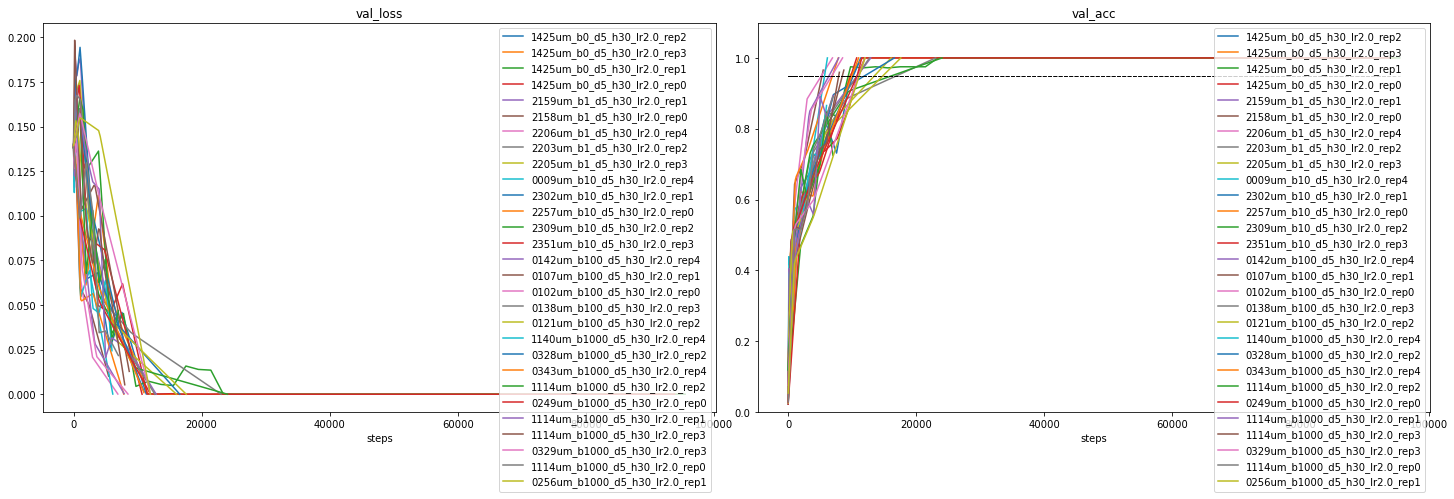

#logged paths : 29 
27239588_1805_1425_synth_um_b0_d6_h30_lr2.0_rep3
fold_3  #logged: 2583, Max_acc: 1.0 Max_step: 94583 
#folds: 1
27239587_1805_1425_synth_um_b0_d6_h30_lr2.0_rep2
fold_2  #logged: 2595, Max_acc: 1.0 Max_step: 94732 
#folds: 1
27239585_1805_1425_synth_um_b0_d6_h30_lr2.0_rep0
fold_0  #logged: 2546, Max_acc: 1.0 Max_step: 92867 
#folds: 1
27239586_1805_1425_synth_um_b0_d6_h30_lr2.0_rep1
fold_1  #logged: 2648, Max_acc: 1.0 Max_step: 95492 
#folds: 1
27252618_2205_2223_synth_um_b1_d6_h30_lr2.0_rep3
fold_3  #logged: 7, Max_acc: 1.0 Max_step: 14713 
#folds: 1
27252617_2205_2219_synth_um_b1_d6_h30_lr2.0_rep2
fold_2  #logged: 7, Max_acc: 1.0 Max_step: 16581 
#folds: 1
27252619_2205_2254_synth_um_b1_d6_h30_lr2.0_rep4
fold_4  #logged: 6, Max_acc: 0.966 Max_step: 8610 
#folds: 1
27252615_2205_2208_synth_um_b1_d6_h30_lr2.0_rep0
fold_0  #logged: 7, Max_acc: 1.0 Max_step: 19446 
#folds: 1
27252616_2205_2211_synth_um_b1_d6_h30_lr2.0_rep1
fold_1  #logged: 6, Max_acc: 0.984 Max_step: 1

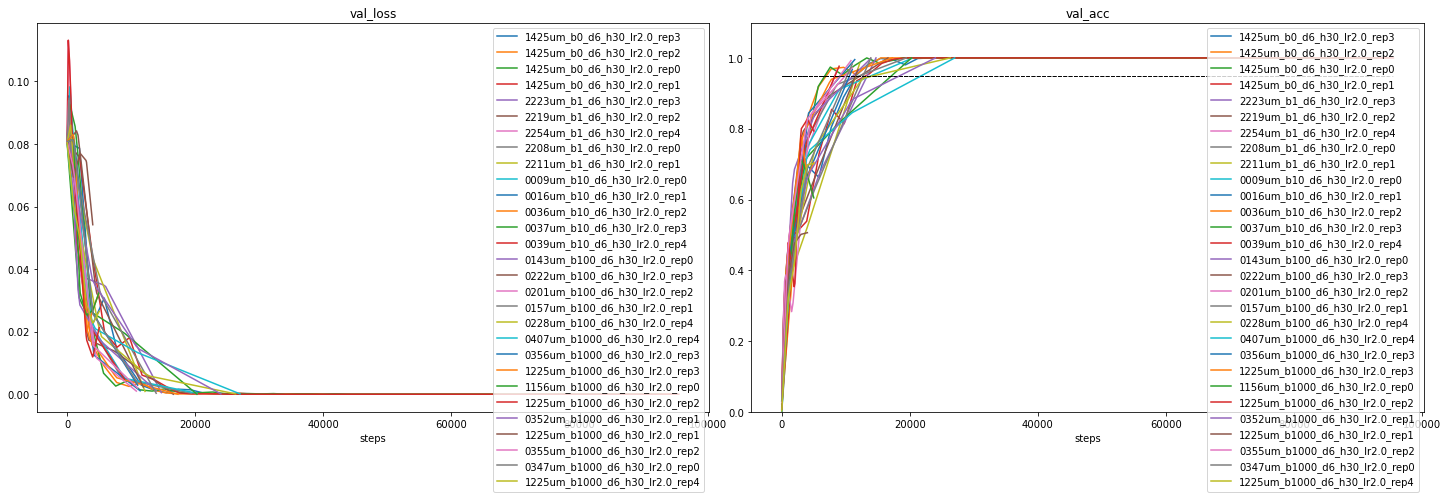

#logged paths : 4 
27239590_1805_1425_synth_um_b0_d7_h125_lr2.0_rep0
fold_0  #logged: 2507, Max_acc: 0.979 Max_step: 91257 
#folds: 1
27239592_1805_1425_synth_um_b0_d7_h125_lr2.0_rep2
fold_2  #logged: 2516, Max_acc: 0.985 Max_step: 91847 
#folds: 1
27239591_1805_1425_synth_um_b0_d7_h125_lr2.0_rep1
fold_1  #logged: 2580, Max_acc: 1.0 Max_step: 91011 
#folds: 1
27239593_1805_1425_synth_um_b0_d7_h125_lr2.0_rep3
fold_3  #logged: 2512, Max_acc: 0.999 Max_step: 91856 
#folds: 1


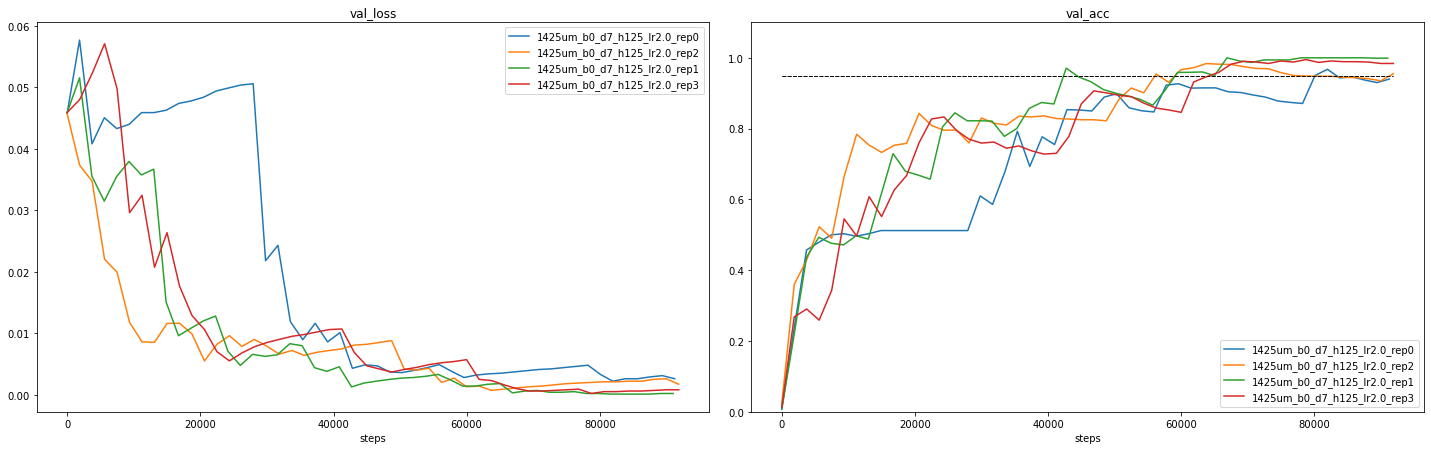

#logged paths : 17 
27247030_1905_1505_synth_um_b0_d7_h250_lr2.0_rep2
fold_2  #logged: 2468, Max_acc: 0.997 Max_step: 89846 
#folds: 1
27247029_1905_1505_synth_um_b0_d7_h250_lr2.0_rep1
fold_1  #logged: 2638, Max_acc: 1.0 Max_step: 93300 
#folds: 1
27247031_1905_1505_synth_um_b0_d7_h250_lr2.0_rep3
fold_3  #logged: 2525, Max_acc: 1.0 Max_step: 92413 
#folds: 1
27247028_1905_1505_synth_um_b0_d7_h250_lr2.0_rep0
fold_0  #logged: 2550, Max_acc: 0.985 Max_step: 92714 
#folds: 1
27252654_2305_0427_synth_um_b1_d7_h250_lr2.0_rep1
fold_1  #logged: 7, Max_acc: 0.934 Max_step: 36579 
#folds: 1
27252653_2305_0409_synth_um_b1_d7_h250_lr2.0_rep0
fold_0  #logged: 7, Max_acc: 0.793 Max_step: 38571 
#folds: 1
27252655_2305_0435_synth_um_b1_d7_h250_lr2.0_rep2
fold_2  #logged: 7, Max_acc: 0.977 Max_step: 36372 
#folds: 1
27252656_2305_0502_synth_um_b1_d7_h250_lr2.0_rep3
fold_3  #logged: 7, Max_acc: 0.744 Max_step: 32916 
#folds: 1
27252657_2305_0507_synth_um_b1_d7_h250_lr2.0_rep4
fold_4  #logged: 7, Max_ac

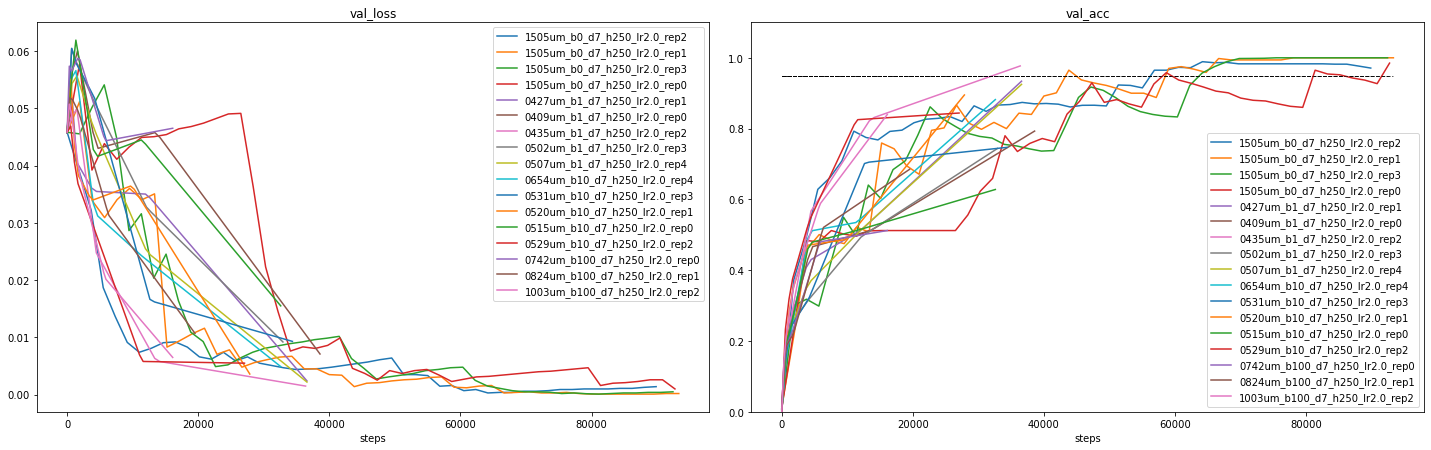

#logged paths : 4 
27239572_1805_1322_synth_um_b0_d8_h250_lr5.0_rep1
fold_1  #logged: 1839, Max_acc: 1.0 Max_step: 88924 
#folds: 1
27239571_1805_1311_synth_um_b0_d8_h250_lr5.0_rep0
fold_0  #logged: 1840, Max_acc: 0.981 Max_step: 87976 
#folds: 1
27239573_1805_1346_synth_um_b0_d8_h250_lr5.0_rep2
fold_2  #logged: 1907, Max_acc: 0.988 Max_step: 90831 
#folds: 1
27239574_1805_1353_synth_um_b0_d8_h250_lr5.0_rep3
fold_3  #logged: 1931, Max_acc: 0.986 Max_step: 93052 
#folds: 1


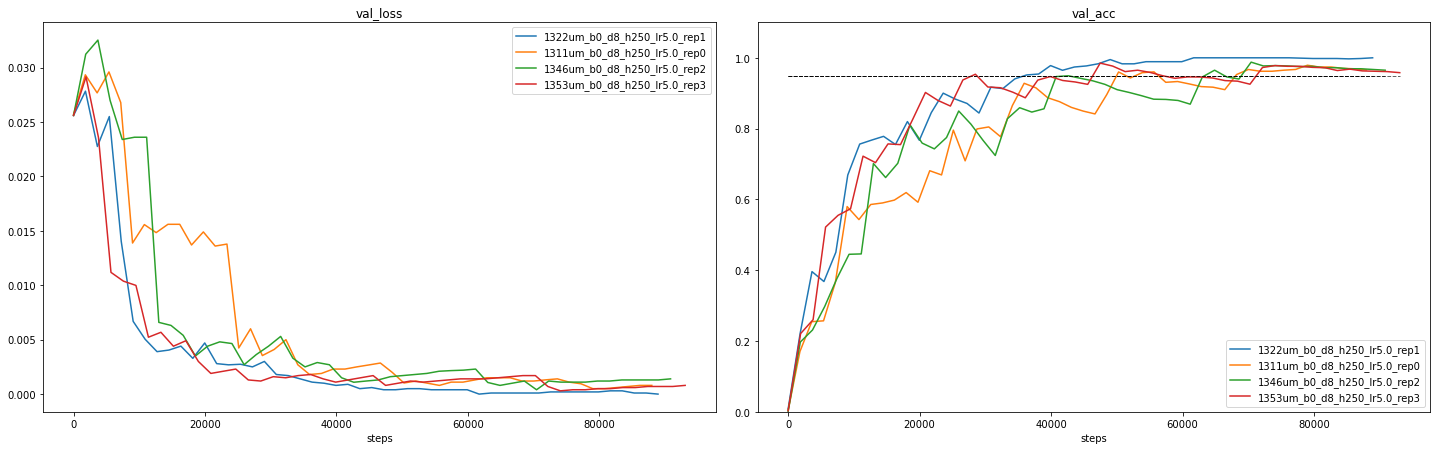

#logged paths : 4 
27247037_1905_1511_synth_um_b0_d8_h500_lr5.0_rep0
fold_0  #logged: 1031, Max_acc: 0.991 Max_step: 87524 
#folds: 1
27247040_1905_1544_synth_um_b0_d8_h500_lr5.0_rep3
fold_3  #logged: 1064, Max_acc: 0.993 Max_step: 88974 
#folds: 1
27247039_1905_1542_synth_um_b0_d8_h500_lr5.0_rep2
fold_2  #logged: 1059, Max_acc: 0.992 Max_step: 87544 
#folds: 1
27247038_1905_1536_synth_um_b0_d8_h500_lr5.0_rep1
fold_1  #logged: 1073, Max_acc: 1.0 Max_step: 89855 
#folds: 1


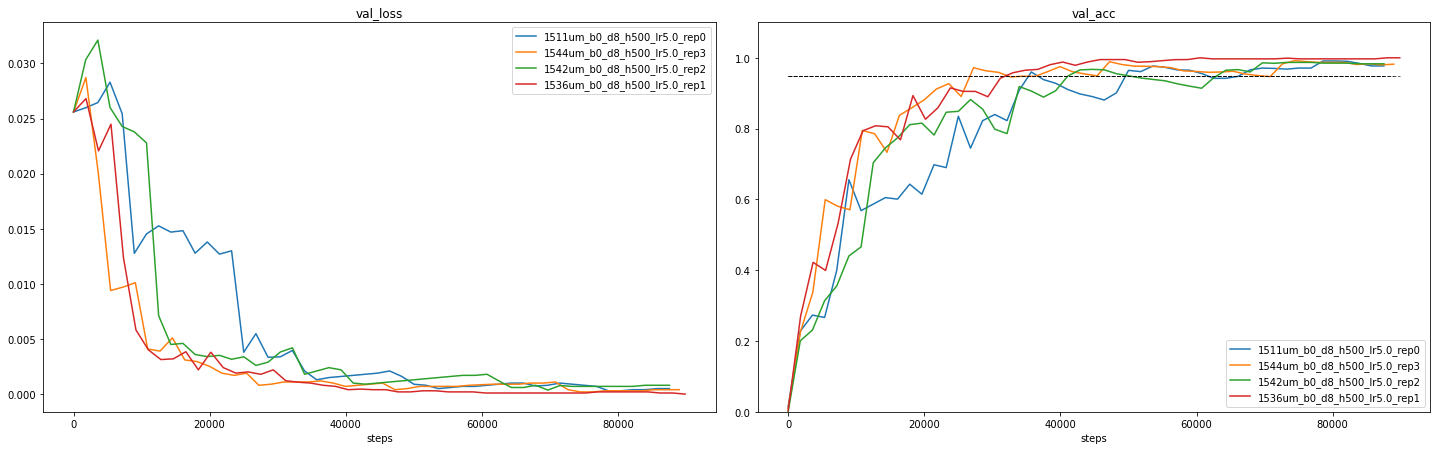

#logged paths : 4 
27239576_1805_1425_synth_um_b0_d9_h500_lr5.0_rep0
fold_0  #logged: 1329, Max_acc: 0.998 Max_step: 82110 
#folds: 1
27239578_1805_1425_synth_um_b0_d9_h500_lr5.0_rep2
fold_2  #logged: 1318, Max_acc: 0.991 Max_step: 83083 
#folds: 1
27239577_1805_1425_synth_um_b0_d9_h500_lr5.0_rep1
fold_1  #logged: 1305, Max_acc: 0.984 Max_step: 81456 
#folds: 1
27239579_1805_1425_synth_um_b0_d9_h500_lr5.0_rep3
fold_3  #logged: 1314, Max_acc: 0.999 Max_step: 82041 
#folds: 1


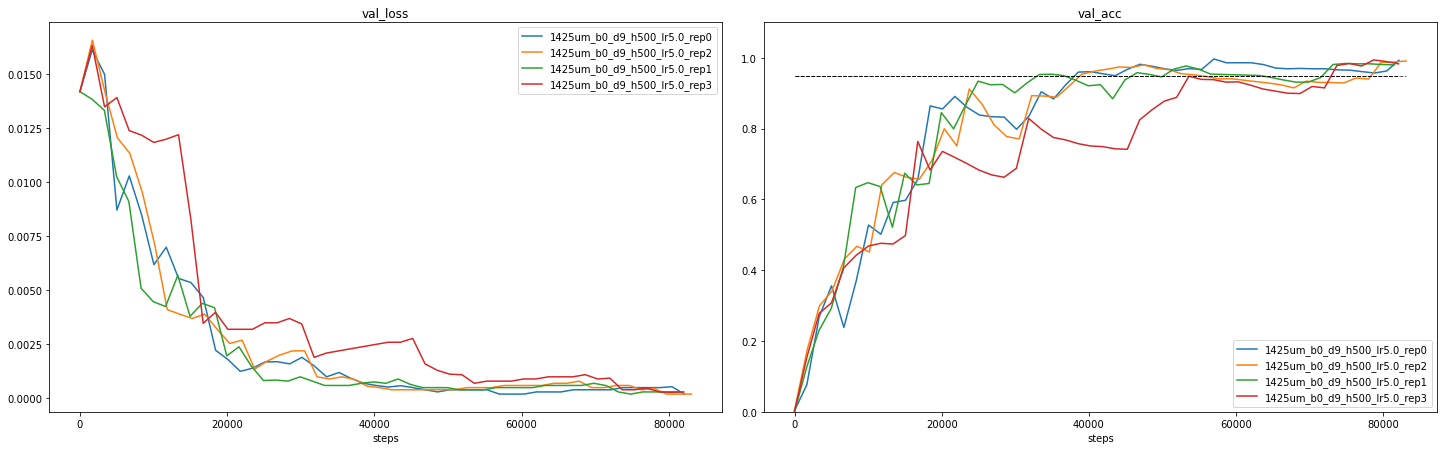

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#logged paths : 0 


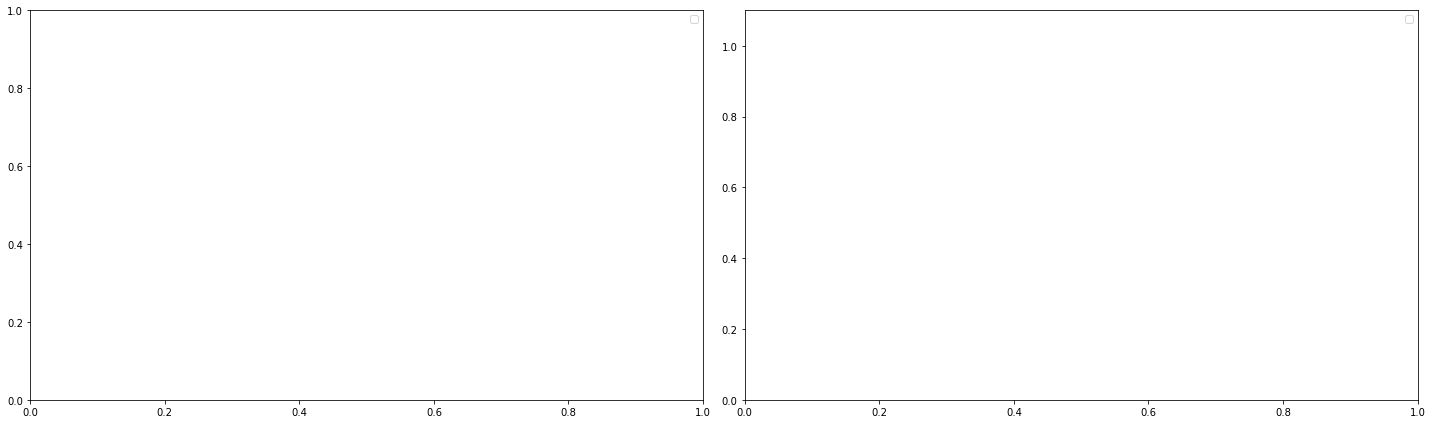

In [793]:
patts_to_search2 = ["um_b0_d5", "um_b0_d6", "um_b0_d7", "um_b0_d8", "um_b0_d9", "um_b0_d10", 
                    "rand_b0_d5", "rand_b0_d6", "rand_b0_d7", "rand_b0_d8", "rand_b0_d9", "rand_b0_d10"]

patt = ["um_b0_d5_h30", 'um_b1_d5_h30', 'um_b10_d5_h30', 'um_b100_d5_h30', 'um_b1000_d5_h30', 'd5_h30',
                    "um_b0_d6_h30", 'um_b1_d6_h30', 'um_b10_d6_h30', 'um_b100_d6_h30', 'um_b1000_d6_h30']

patts_to_search2 = ['d5_h30_lr2','d6_h30_lr2', 'd7_h250_lr2', 'd8_h500_lr5', "d9_h500_lr5", "d10"]
#patts_to_search2 = ["1836_synth_um_b1_d5"]

for patt in patts_to_search2: plot_runs_w_regex(patt, 0.5, DL_LOG_PATH, verbose=True, delete_dir=False)

# Log folds merger

In [788]:
import shutil
import itertools
from collections import Counter
from more_itertools import locate

def get_len_vals(dest_path):
    event_acc_old = EventAccumulator(dest_path)
    event_acc_old.Reload()
    try:
        _, step_nums, vals = zip(*event_acc.Scalars('val_acc'))
        return len(vals)
    except:
        return 0
    
def rename_w_rep(log_path):
    all_ckpt_dirs=os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    for log_dir in all_ckpt_dirs:
        if not 'rep' in log_dir:
            fold_x = os.listdir(join(log_path,log_dir,'metrics'))
            fold_x = [el for el in fold_x if 'fold' in el]
            fold_nb = int(re.match('fold_([0-9]+)', fold_x).group(1))
            os.rename(join(log_path,log_dir), join(log_path,f'{log_dir}_rep{fold_nb}'))
            
def get_folds_to_merge(log_path, all_ckpt_dirs):
    
    patt = "(?:merged_)*([0-9]+)_[0-9]+_[0-9]+_[a-z]+_((?:um|rand)_b[0-9]+_d[0-9]+_h[0-9]+_lr[0-9]+)"
    matched = [re.match(patt, el) for el in all_ckpt_dirs]
    
    idx_true = [int(m.group(1)) > 27166099 for m in matched] # keep only recent matches
    matched = np.array(matched)[idx_true]
    all_ckpt_dirs = np.array(all_ckpt_dirs)[idx_true]
    hashes = [el.group(2) for el in matched] # create hashes
    counts = Counter(hashes)
    dup_hashes = [i for i in counts.keys() if counts[i] > 1] # keep only ckpts w duplicates
    
    folds_to_merge = [all_ckpt_dirs[list(locate(hashes, lambda x: x == hash1))] for hash1 in dup_hashes] # get the actual paths
    print(folds_to_merge)
    folds_to_merge = [[join(log_path, fold, 'metrics') for fold in folds] for folds in folds_to_merge]
    return folds_to_merge
    
def merge_folds(log_path=LOG_PATH):
    rename_w_rep(log_path)
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    
    #all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    folds_to_merge = get_folds_to_merge(log_path, all_ckpt_dirs)
    
    for folds in folds_to_merge: 
        for i, fold in enumerate(folds): 
            assert(os.path.isdir(fold))
            folds_x = os.listdir(fold)
            if len(folds_x) < 1:
                shutil.rmtree(fold)
                del folds[i]
            ds_store=join(fold, '.DS_Store')
            if os.path.isdir(ds_store): os.remove(ds_store)
    
    for folds in folds_to_merge:
        # find smallest fold nb
        prev_fold_nb = 100
        for i, fold in enumerate(folds):
            print(fold)
            min_fold_nb = int(re.match('[a-z0-9./_]*rep([0-9]+)', fold).group(1))
            folds_x = os.listdir(fold)
            folds_x = [el for el in folds_x if "DS_Store" not in el]
            merged_folds_nb = [int(re.match('fold_([0-9]+)', fold_x).group(1)) for fold_x in folds_x]
            if min_fold_nb < prev_fold_nb or ('merged' in fold):
                prev_fold_nb = min_fold_nb
                prev_fold_idx = i
                dest_path = fold
                merged_folds_nb = merged_folds_nb
                if ('merged' in fold): break
        
        if not 'merged' in dest_path:
            dest_path_idx = [i for i, letter in enumerate(dest_path) if letter == '/']
            dest_path_pre = dest_path[:dest_path_idx[2]]
            dest_path_ckpt = dest_path[dest_path_idx[2]+1:dest_path_idx[3]]
            dest_fold_path = dest_path[:dest_path_idx[-1]]
            new_dest_ckpt = f'merged_{dest_path_ckpt}'
            new_dest_fold_path = join(dest_path_pre, new_dest_ckpt)
            os.rename(dest_fold_path, new_dest_fold_path)
            del folds[prev_fold_idx]
            dest_path = join(new_dest_fold_path, 'metrics')
        
        for fold in folds:
            list_folds = os.listdir(fold)
            list_folds = [el for el in list_folds if "DS_Store" not in el]
            foldnb2 = int(re.match('fold_([0-9]+)', list_folds[0]).group(1))
            source_path = join(fold, list_folds[0])
            #print('dest_fold_nb', dest_path, merged_folds_nb, 'foldnb2', source_path, foldnb2)
            merged_folds_nb.append(foldnb2)
            do_move=True

            # Check if file already exists
            hyp_dest_path = join(dest_path, f'fold_{foldnb2}')
            print(hyp_dest_path, source_path)
            if os.path.isdir(hyp_dest_path):
                print(hyp_dest_path,'exists in the destination path!')

                if get_len_vals(hyp_dest_path) < get_len_vals(source_path):
                    shutil.rmtree(hyp_dest_path)
                    print("rem")
                else:
                    do_move=False

            if do_move:
                shutil.move(source_path, dest_path)

            folder = source_path[:source_path[:source_path.rfind('/')].rfind('/')]
            #print("TO remove", folder)
            shutil.rmtree(folder)
                

#27147228_2504_1617_synth_um_b0_d8_h300_lr5
!cd $DL_LOG_PATH
!find . -name '.DS_Store' -type f -delete
!echo DONE
merge_folds(TEST_LOG_PATH)


    

DONE
[array(['27252618_2205_2223_synth_um_b1_d6_h30_lr2.0_rep3',
       '27252617_2205_2219_synth_um_b1_d6_h30_lr2.0_rep2',
       '27252619_2205_2254_synth_um_b1_d6_h30_lr2.0_rep4',
       '27252615_2205_2208_synth_um_b1_d6_h30_lr2.0_rep0',
       '27252616_2205_2211_synth_um_b1_d6_h30_lr2.0_rep1'], dtype='<U59'), array(['27247033_1905_1506_synth_um_b0_d8_h500_lr2.0_rep0',
       '27247036_1905_1506_synth_um_b0_d8_h500_lr2.0_rep3',
       '27247035_1905_1506_synth_um_b0_d8_h500_lr2.0_rep2',
       '27247034_1905_1506_synth_um_b0_d8_h500_lr2.0_rep1'], dtype='<U59'), array(['27252649_2305_0407_synth_um_b1000_d6_h30_lr2.0_rep4',
       '27252648_2305_0356_synth_um_b1000_d6_h30_lr2.0_rep3',
       '27252646_2305_0352_synth_um_b1000_d6_h30_lr2.0_rep1',
       '27252647_2305_0355_synth_um_b1000_d6_h30_lr2.0_rep2',
       '27252645_2305_0347_synth_um_b1000_d6_h30_lr2.0_rep0'],
      dtype='<U59'), array(['27247030_1905_1505_synth_um_b0_d7_h250_lr2.0_rep2',
       '27247029_1905_1505_synth_um

In [765]:
def clean_folds(log_path=LOG_PATH):    
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [join(log_path, ckpt_path, 'metrics') for ckpt_path in all_ckpt_dirs]
    
    for ckpt in all_ckpt_dirs:
        folds = os.listdir(ckpt)
        for el in folds:
            if 'fold' not in el:
                el = join(ckpt, el)
                if os.path.isdir(el):
                    shutil.rmtree(el)
                else:
                    os.remove(el)
                
clean_folds(log_path=DL_LOG_PATH)    

[200, 500, 1000, 1300, 1700, 2200, 2900, 3800, 4900, 6400, 8300] 11
[300, 700, 1500, 1900, 2500, 3300, 4300, 5700, 7400, 9600, 12500] 11


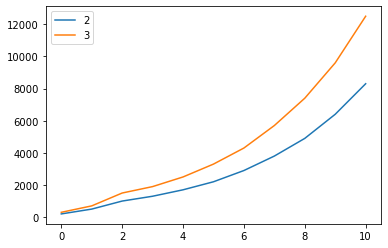

In [631]:
b_l=100

for a in range(2,4):
    a0=a
    b=[]
    for i in range(17):
        if i < 9: 
            #a*=2.8
            a*=2
        else:
            a*=1.3
        b.append(a)
    b = [int((el // b_l) * b_l) for el in b] 
    b = [el for el in b if el > b_l] 
    print(b, len(b))
    plt.plot(b, label=a0)    
plt.legend()
plt.show()

In [607]:
a = 0 if True else 1
a

0